Starting Monte Carlo simulation with 1000 data points...


Monte Carlo Simulation: 100%|██████████| 1000/1000 [00:00<00:00, 12378.68it/s]

Monte Carlo simulation completed in 0.11 seconds.
Shape of simulated series: (1000, 1000)


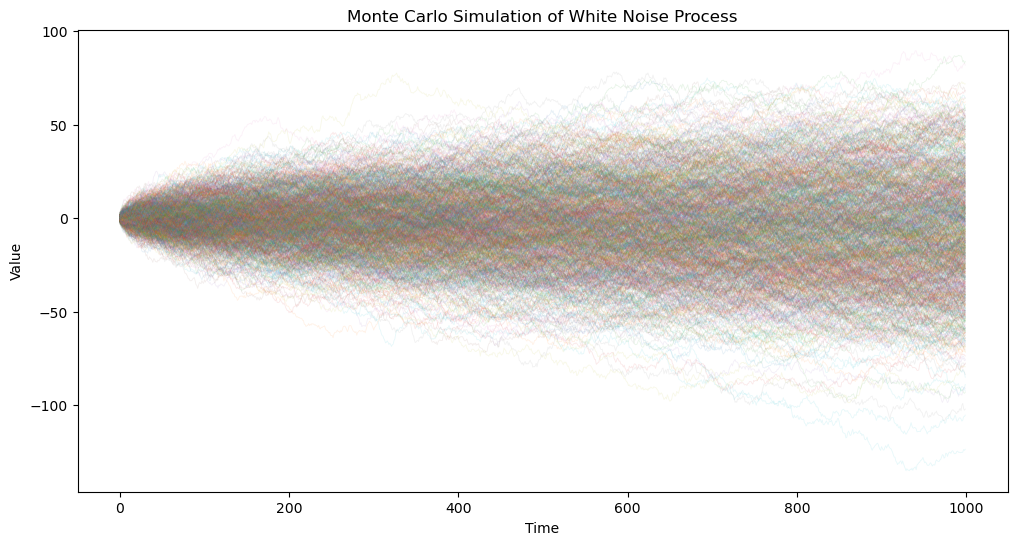

Script execution completed.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

def generate_white_noise(n=1000, mean=0, std_dev=1):
    return np.random.normal(mean, std_dev, n)

def simulate_path(series):
    return np.cumsum(np.random.choice(series, size=len(series)))

def monte_carlo_simulation(series, num_simulations=1000):
    simulated_series = []
    for _ in tqdm(range(num_simulations), desc="Monte Carlo Simulation"):
        simulated_series.append(simulate_path(series))
    return np.array(simulated_series)

def plot_monte_carlo_simulation(simulated_series):
    plt.figure(figsize=(12, 6))
    for simulation in simulated_series:
        plt.plot(simulation, linewidth=0.6, alpha=0.1)
    plt.title('Monte Carlo Simulation of White Noise Process')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.show()

def main():
    # Generate white noise
    n = 1000
    white_noise = generate_white_noise(n=n)
    
    # Perform Monte Carlo simulation
    print(f"Starting Monte Carlo simulation with {n} data points...")
    start_time = time.time()
    try:
        simulated_series = monte_carlo_simulation(white_noise, num_simulations=1000)
        print(f"Monte Carlo simulation completed in {time.time() - start_time:.2f} seconds.")
        print(f"Shape of simulated series: {simulated_series.shape}")
        
        # Plot the results
        plot_monte_carlo_simulation(simulated_series)
    except Exception as e:
        print(f"An error occurred during simulation: {str(e)}")
    
    print("Script execution completed.")

if __name__ == "__main__":
    main()